In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from math import ceil, log2
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize
import time
import warnings
warnings.filterwarnings("ignore")

In [127]:
SEED = 42
np.random.seed(SEED)

In [128]:
TICKER = "AAPL"        # change to any ticker (e.g., "SPY", "MSFT")
PERIOD = "5y"          # e.g., '5y', '2y'
INTERVAL = "1d"


In [129]:
def fetch_and_features(ticker=TICKER, period=PERIOD, interval=INTERVAL):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True)
    df = df.dropna()
    df['returns'] = df['Close'].pct_change().fillna(0)
    df['logret'] = np.log1p(df['returns'])
    df['ma_5'] = df['Close'].rolling(5).mean()
    df['ma_20'] = df['Close'].rolling(20).mean()
    df['vol_20'] = df['logret'].rolling(20).std()
    df['momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df = df.dropna()
    return df

In [130]:
df = fetch_and_features(TICKER, PERIOD, INTERVAL)
print("Data shape:", df.shape)
df.tail()

[*********************100%***********************]  1 of 1 completed

Data shape: (1237, 11)


Price,Close,High,Low,Open,Volume,returns,logret,ma_5,ma_20,vol_20,momentum_5
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2025-11-03,269.049988,270.850006,266.250000,270.420013,50194600,-0.004882,-0.004894,269.903998,259.127499,0.015418,0.000893
2025-11-04,270.040009,271.489990,267.619995,268.329987,49274800,0.003680,0.003673,270.112000,259.805499,0.015402,0.003866
2025-11-05,270.140015,271.700012,266.929993,268.609985,43683100,0.000370,0.000370,270.200000,260.409499,0.015386,0.001631
2025-11-06,269.769989,273.399994,267.890015,267.890015,51204000,-0.001370,-0.001371,269.873999,261.195999,0.014828,-0.006006
2025-11-07,268.470001,272.290009,266.769989,269.799988,48203600,-0.004819,-0.004831,269.494000,262.355999,0.012006,-0.007027


In [131]:
FEATURE_COLS = ['logret','ma_5','ma_20','vol_20','momentum_5']
X = df[FEATURE_COLS].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [132]:
angle_scaler = MinMaxScaler(feature_range=(0, np.pi))
X_angles = angle_scaler.fit_transform(Xs)

In [133]:
SUBSET_SIZE = 120   # adjust; keep small if you want fast training
if SUBSET_SIZE > X_angles.shape[0]:
    SUBSET_SIZE = X_angles.shape[0]

In [134]:
X_sub = X_angles[-SUBSET_SIZE:].copy()
index_sub = df.index[-SUBSET_SIZE:]


In [135]:
forward_ret = df['returns'].shift(-1).loc[index_sub].fillna(0).values
y_target = np.where(forward_ret >= 0, 1.0, -1.0)

In [136]:
print("Subset shape:", X_sub.shape, "Target counts:", np.unique(y_target, return_counts=True))

Subset shape: (120, 5) Target counts: (array([-1.,  1.]), array([52, 68]))


In [137]:
n_features = X_sub.shape[1]
n_qubits = int(ceil(log2(n_features)))
dim = 2**n_qubits
print(f"Features: {n_features}, using {n_qubits} qubits (amplitude dim {dim})")

Features: 5, using 3 qubits (amplitude dim 8)


In [138]:
n_layers = 1 

In [139]:
dev = qml.device("default.qubit", wires=n_qubits)

In [140]:
# @qml.qnode(dev)
# def state_circuit(x_angles, theta_flat):
#     # x_angles: length n_features (<= dim); pad/truncate to dim then set RZ on each qubit
#     x = np.array(x_angles, dtype=float)
#     # pad x to dim if necessary (we already used scaling to angles)
#     if len(x) < dim:
#         x = np.concatenate([x, np.zeros(dim - len(x))])
#     # Map classical vector to qubit angles: apply RZ on each wire using first n_qubits elements
#     for i in range(n_qubits):
#         # qml.RZ(float(x[i]), wires=i)
#         qml.RY(float(x[i]), wires=i)
#            # static encoding
#     # variational layer(s)
#     # theta_flat is a 1D vector: length = n_layers * n_qubits * 2  (we use RX and RZ per qubit per layer)
#     thetas = np.array(theta_flat, dtype=float)
#     thetas = thetas.reshape((n_layers, n_qubits, 2))
#     for layer in range(n_layers):
#         for q in range(n_qubits):
#             qml.RX(thetas[layer,q,0], wires=q)
#             qml.RZ(thetas[layer,q,1], wires=q)
#         # entangling chain
#         for q in range(n_qubits - 1):
#             qml.CNOT(wires=[q, q+1])
#     return qml.state()

In [141]:
@qml.qnode(dev)
def state_circuit(x_angles, theta_flat):
    # angle embedding (first n_qubits values)
    qml.templates.AngleEmbedding(x_angles[:n_qubits], wires=range(n_qubits), rotation='Y')
    # then variational layers (same as before)
    thetas = np.array(theta_flat, dtype=float).reshape((n_layers, n_qubits, 2))
    for layer in range(n_layers):
        for q in range(n_qubits):
            qml.RX(thetas[layer,q,0], wires=q)
            qml.RZ(thetas[layer,q,1], wires=q)
        for q in range(n_qubits-1):
            qml.CNOT(wires=[q, q+1])
    return qml.state()


In [142]:
def states_for_theta(X_inputs, theta_flat, progress=False):
    """Return list/array of statevectors for each input and theta."""
    m = X_inputs.shape[0]
    states = []
    t0 = time.time()
    for i in range(m):
        sv = state_circuit(X_inputs[i], theta_flat)
        states.append(np.array(sv))
        if progress and (i+1) % 20 == 0:
            print(f"Computed state {i+1}/{m}")
    t1 = time.time()
    # print(f"States computed in {t1-t0:.2f}s")
    return np.vstack(states) 

In [143]:
def fidelity_kernel_from_states(states):
    """Given states (m x dim), return K with entries |<psi_i|psi_j>|^2."""
    # states may be complex; compute overlap matrix
    overlaps = np.dot(states, states.conj().T)   # shape (m,m)
    K = np.abs(overlaps)**2
    return K

In [144]:
theta0 = np.random.normal(0, 0.1, size=(n_layers * n_qubits * 2))
states = states_for_theta(X_sub, theta0, progress=True)
K0 = fidelity_kernel_from_states(states)
print("K0 shape:", K0.shape, "K0 sample:", K0[:3,:3])

Computed state 20/120
Computed state 40/120
Computed state 60/120
Computed state 80/120
Computed state 100/120
Computed state 120/120
K0 shape: (120, 120) K0 sample: [[1.         0.99105627 0.99689184]
 [0.99105627 1.         0.98296709]
 [0.99689184 0.98296709 1.        ]]


In [145]:
def kernel_target_alignment(K, y):
    """Normalized Frobenius inner product between kernel K and label kernel yy^T."""
    Y = np.outer(y, y)   # shape (m,m)
    num = np.sum(K * Y)
    den = np.linalg.norm(K, 'fro') * np.linalg.norm(Y, 'fro') + 1e-12
    return num / den

In [146]:
def objective_theta(theta_flat, X_inputs, y):
    """Objective to minimize: negative alignment (we want to maximize alignment)."""
    # compute states and kernel
    states = states_for_theta(X_inputs, theta_flat, progress=False)
    K = fidelity_kernel_from_states(states)
    align = kernel_target_alignment(K, y)
    loss = -align  # we minimize negative alignment
    return float(loss)

In [147]:
print("Initial loss:", objective_theta(theta0, X_sub, y_target))

Initial loss: -0.015017937292716391


In [148]:
from functools import partial

maxiter = 80           # adjust depending on how much compute time you want to commit
theta_init = np.random.normal(0, 0.5, size=(n_layers * n_qubits * 2))

print("Starting optimization (this will call the simulator many times)...")
start = time.time()
res = minimize(fun=partial(objective_theta, X_inputs=X_sub, y=y_target),
               x0=theta_init,
               method='COBYLA',
               options={'maxiter': maxiter, 'tol':1e-3, 'rhobeg':0.5})
end = time.time()
theta_opt = res.x
print("Optimization completed in %.1f s. Success: %s, msg: %s" % (end-start, res.success, res.message))
print("Final loss:", res.fun)

Starting optimization (this will call the simulator many times)...
Optimization completed in 10.9 s. Success: True, msg: Optimization terminated successfully.
Final loss: -0.015017937292716393


Initial alignment: 0.015017937292716405
Trained alignment: 0.015017937292716393


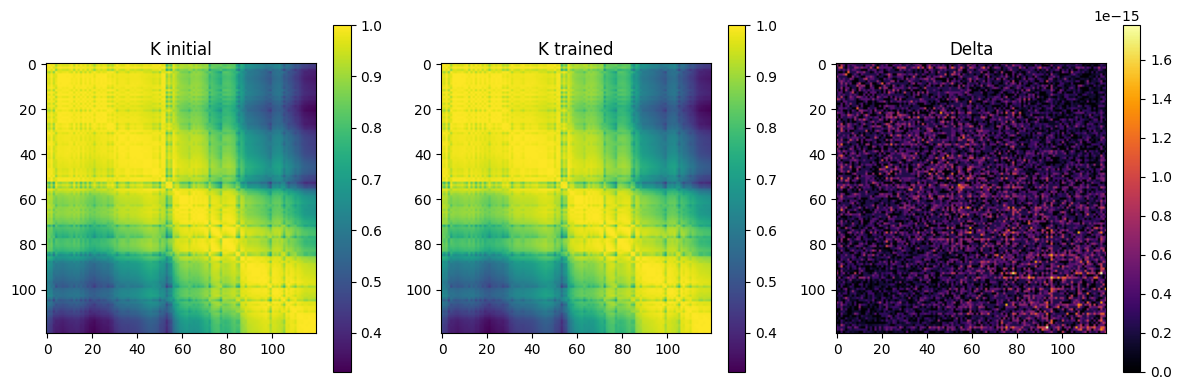

In [149]:
states_init = states_for_theta(X_sub, theta_init)
K_init = fidelity_kernel_from_states(states_init)
states_opt = states_for_theta(X_sub, theta_opt)
K_opt = fidelity_kernel_from_states(states_opt)

print("Initial alignment:", kernel_target_alignment(K_init, y_target))
print("Trained alignment:", kernel_target_alignment(K_opt, y_target))

# visualize small block of kernel matrices
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(K_init, cmap='viridis'); plt.title('K initial'); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(K_opt, cmap='viridis'); plt.title('K trained'); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(np.abs(K_opt - K_init), cmap='inferno'); plt.title('Delta'); plt.colorbar()
plt.tight_layout()
plt.show()

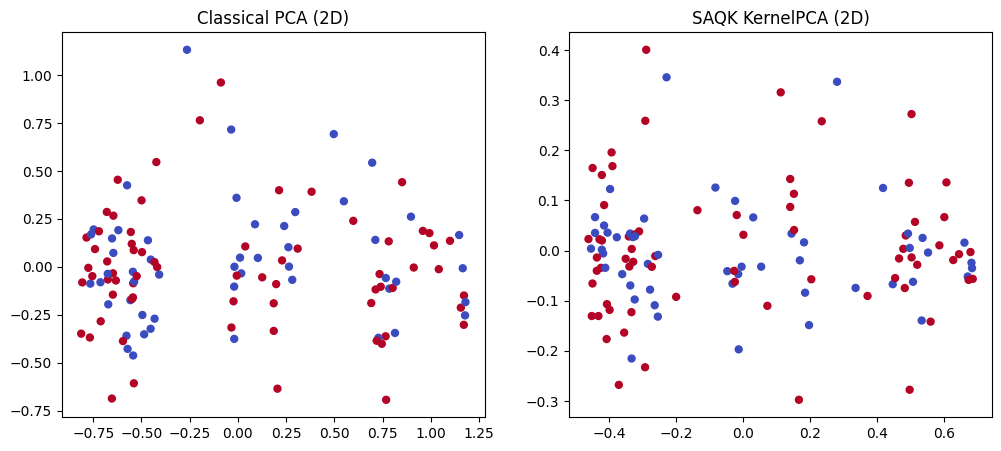

In [150]:
n_components = 3
kpca = KernelPCA(n_components=n_components, kernel='precomputed')
Zq = kpca.fit_transform(K_opt)   # shape (m, n_components)

# For comparison: classical PCA on same scaled features
pca = PCA(n_components=n_components)
Zc = pca.fit_transform(X_sub)

# plot first 2 components for both
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Zc[:,0], Zc[:,1], c=y_target, cmap='coolwarm', s=25)
plt.title('Classical PCA (2D)')
plt.subplot(1,2,2)
plt.scatter(Zq[:,0], Zq[:,1], c=y_target, cmap='coolwarm', s=25)
plt.title('SAQK KernelPCA (2D)')
plt.show()

In [151]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(Zq)
clusters = kmeans.labels_
sil = silhouette_score(Zq, clusters)
print("Silhouette score (SAQK embedding):", sil)

# compute forward returns (already extracted earlier in y_target calculation)
forward_returns_full = df['returns'].shift(-1).loc[index_sub].fillna(0)

cluster_perf = {}
for c in range(n_clusters):
    mask = clusters == c
    cluster_perf[c] = forward_returns_full.values[mask].mean()
print("Cluster forward mean returns:", cluster_perf)

best_cluster = max(cluster_perf, key=cluster_perf.get)
print("Selected cluster to long:", best_cluster)

signals = (clusters == best_cluster).astype(int)

Silhouette score (SAQK embedding): 0.5841487263002371
Cluster forward mean returns: {0: np.float64(0.003663353328503197), 1: np.float64(0.0016563897763181208), 2: np.float64(0.0019631546325627343)}
Selected cluster to long: 0


In [152]:
def backtest(signals, returns, cost_per_trade=0.0005):
    pos = pd.Series(signals, index=index_sub).shift(1).fillna(0)
    strat_rets = pos.values * returns.values
    trades = np.abs(np.diff(np.concatenate([[0], pos.values])))
    strat_rets = strat_rets - trades * cost_per_trade
    equity = np.cumprod(1 + strat_rets)
    return strat_rets, equity

In [153]:
rets_sub_series = df['returns'].loc[index_sub]
strat_rets, equity = backtest(signals, rets_sub_series)

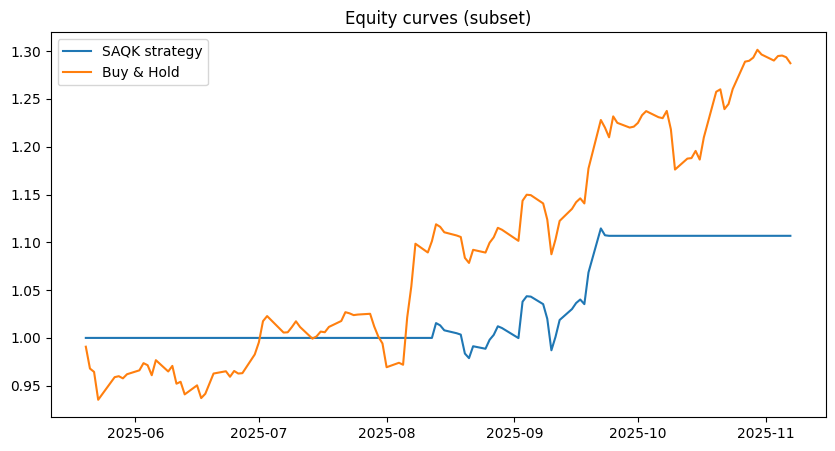

In [154]:
bh_equity = np.cumprod(1 + rets_sub_series.values)

plt.figure(figsize=(10,5))
plt.plot(index_sub, equity, label='SAQK strategy')
plt.plot(index_sub, bh_equity, label='Buy & Hold')
plt.legend(); plt.title('Equity curves (subset)')
plt.show()

In [155]:
def sharpe(returns, freq=252):
    return np.mean(returns) / (np.std(returns) + 1e-9) * np.sqrt(freq)

In [156]:
print("SAQK strategy total return:", equity[-1]-1, "Sharpe:", sharpe(strat_rets))
print("Buy & Hold total return:", bh_equity[-1]-1, "Sharpe:", sharpe(rets_sub_series.values))

SAQK strategy total return: 0.10680443473984447 Sharpe: 1.7589652251349912
Buy & Hold total return: 0.2873584327905834 Sharpe: 2.43136297530275


In [157]:
out = pd.DataFrame(index=index_sub)
out['cluster'] = clusters
out['signal'] = signals
out['next_return'] = df['returns'].shift(-1).loc[index_sub].fillna(0)
out['strategy_ret'] = np.concatenate([[0], np.diff(equity) / equity[:-1]])  # approximate daily strat ret
out.to_csv('saqk_stock_results.csv')
print("Saved results to saqk_stock_results.csv")

print("Final summary:")
print(" - Subset size:", len(index_sub))
print(" - Trained alignment:", kernel_target_alignment(K_opt, y_target))
print(" - Silhouette:", sil)
print(" - Strategy total return:", equity[-1]-1)
print(" - Strategy Sharpe:", sharpe(strat_rets))

Saved results to saqk_stock_results.csv
Final summary:
 - Subset size: 120
 - Trained alignment: 0.015017937292716393
 - Silhouette: 0.5841487263002371
 - Strategy total return: 0.10680443473984447
 - Strategy Sharpe: 1.7589652251349912
